In [1]:
# Test dataset loading

In [16]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
from torch.utils.data import DataLoader

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import lightning as L
from lightning.pytorch.loggers import MLFlowLogger

import pandas as pd

import numpy as np


import sys
sys.path.append('./datasets')
sys.path.append('./models')

# import datasets
from UNSW_NB15_Custom import UNSWNB15Dataset_Custom, load_UNSWNB15Dataset, split_UNSWNB15Dataset
from UNSW_NB15 import UNSWNB15Dataset
from KDDCUP99 import KDDCUP99Dataset
from CICIDS2017 import CICIDS2017Dataset

# import models
from StandardAE import StandardAE
from BAE import BAE
from SAE import SAE

from IStandardAE import IStandardAE


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data_dir = Path("../data/UNSW-NB15/preprocessed")
data = load_UNSWNB15Dataset(data_dir)

In [7]:
num_all_records = len(data)
num_normal_records = len(data[data["Label"] == 0])
num_attack_records = len(data[data["Label"] == 1])

print("total num records:   ", num_all_records)
print("normal records:      ", num_normal_records)
print("attack records:      ", num_attack_records)

total num records:    2540047
normal records:       2218764
attack records:       321283


In [3]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median').set_output(transform='pandas')),
    ('scaler', StandardScaler().set_output(transform='pandas'))
])

In [11]:
# full dataset

val_test_size = (num_attack_records // 2) * 2
train_size = num_normal_records - val_test_size

train_dataset, val_dataset, test_dataset = split_UNSWNB15Dataset( 
                                                        data_dir = data_dir,
                                                        data = data,
                                                        records_num = {"train" : train_size, "val" : val_test_size, "test" : val_test_size},
                                                        normal_records_num = {"train" : 1.0, "val" : 0.5, "test" : 0.5},
                                                        transformer = pipeline,
                                                        random_state = 42)

In [7]:
# small dataset
train_dataset, val_dataset, test_dataset = split_UNSWNB15Dataset( 
                                                        data_dir = data_dir,
                                                        data = data,
                                                        records_num = {"train" : 1e5, "val" : 1e5, "test" : 1e5},
                                                        normal_records_num = {"train" : 1.0, "val" : 0.5, "test" : 0.5},
                                                        transformer = pipeline,
                                                        random_state = 42)

In [4]:
# KDDCUP99
data_dir = Path("../data/KDDCUP99/preprocessed")
KDDCUP99_train_dataset = KDDCUP99Dataset(data_dir, type = "train", transformer = pipeline)
KDDCUP99_val_dataset = KDDCUP99Dataset(data_dir, type = "val", transformer = pipeline)
KDDCUP99_test_dataset = KDDCUP99Dataset(data_dir, type = "test", transformer = pipeline)



Loaded train data with 912188 samples.
Data shape: (912188, 125)
num_anomalies: 0
num_normal: 912188
anomaly ratio: 0.0

Loaded val data with 311029 samples.
Data shape: (311029, 125)
num_anomalies: 250436
num_normal: 60593
anomaly ratio: 0.8051853685669182

Loaded test data with 311029 samples.
Data shape: (311029, 125)
num_anomalies: 250436
num_normal: 60593
anomaly ratio: 0.8051853685669182


In [5]:
# UNSWNB15
data_dir = Path("../data/UNSW-NB15/preprocessed")
UNSWNB15_train_dataset = UNSWNB15Dataset(data_dir, type = "train", transformer = pipeline)
UNSWNB15_val_dataset = UNSWNB15Dataset(data_dir, type = "val", transformer = pipeline)
UNSWNB15_test_dataset = UNSWNB15Dataset(data_dir, type = "test", transformer = pipeline)


Loaded train data with 46000 samples.
Data shape: (46000, 196)
num_anomalies: 0
num_normal: 46000
anomaly ratio: 0.0

Loaded val data with 22252 samples.
Data shape: (22252, 196)
num_anomalies: 12252
num_normal: 10000
anomaly ratio: 0.5506021930612979

Loaded test data with 82332 samples.
Data shape: (82332, 196)
num_anomalies: 45332
num_normal: 37000
anomaly ratio: 0.5506000097167566


In [6]:
# CICIDS2017

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan).set_output(transform='pandas')),
    ('scaler', StandardScaler().set_output(transform='pandas'))
])

data_dir = Path("../data/CIC-IDS2017/preprocessed")
CICIDS2017_train_dataset = CICIDS2017Dataset(data_dir, type = "train", transformer = pipeline)
CICIDS2017_val_dataset = CICIDS2017Dataset(data_dir, type = "val", transformer = pipeline)
CICIDS2017_test_dataset = CICIDS2017Dataset(data_dir, type = "test", transformer = pipeline)


Loaded train data with 1715451 samples.
Data shape: (1715451, 80)
num_anomalies: 0
num_normal: 1715451
anomaly ratio: 0.0
columns with missing values:
['Flow Bytes/s', 'Flow Packets/s']
columns with infinity values:
[]

Loaded val data with 557646 samples.
Data shape: (557646, 80)
num_anomalies: 278823
num_normal: 278823
anomaly ratio: 0.5
columns with missing values:
['Flow Bytes/s', 'Flow Packets/s']
columns with infinity values:
[]

Loaded test data with 557646 samples.
Data shape: (557646, 80)
num_anomalies: 278823
num_normal: 278823
anomaly ratio: 0.5
columns with missing values:
['Flow Bytes/s', 'Flow Packets/s']
columns with infinity values:
[]


In [8]:
KDDCUP99_train_loader = DataLoader(KDDCUP99_train_dataset, batch_size=1024, shuffle=True, num_workers=11, persistent_workers=True)
KDDCUP99_val_loader = DataLoader(KDDCUP99_val_dataset, batch_size=1024, shuffle=False, num_workers=11, persistent_workers=True)
KDDCUP99_test_loader = DataLoader(KDDCUP99_test_dataset, batch_size=1024, shuffle=False, num_workers=11, persistent_workers=True)

In [4]:
UNSWNB15_train_loader = DataLoader(UNSWNB15_train_dataset, batch_size=1024, shuffle=True, num_workers=11, persistent_workers=True)
UNSWNB15_val_loader = DataLoader(UNSWNB15_val_dataset, batch_size=1024, shuffle=False, num_workers=11, persistent_workers=True)
UNSWNB15_test_loader = DataLoader(UNSWNB15_test_dataset, batch_size=1024, shuffle=False, num_workers=11, persistent_workers=True)

In [9]:
CICIDS2017_train_loader = DataLoader(CICIDS2017_train_dataset, batch_size=1024, shuffle=True, num_workers=11, persistent_workers=True)
CICIDS2017_val_loader = DataLoader(CICIDS2017_val_dataset, batch_size=1024, shuffle=False, num_workers=11, persistent_workers=True)
CICIDS2017_test_loader = DataLoader(CICIDS2017_test_dataset, batch_size=1024, shuffle=False, num_workers=11, persistent_workers=True)

In [29]:
for x, y, attack_cat in KDDCUP99_train_loader:
    print(x)
    print(y)
    print(attack_cat)
    break

print("train dataset size:", len(train_dataset))

tensor([[-2.0893e-01, -1.5198e-01, -1.3252e-01,  ..., -3.5531e-02,
         -4.6626e-03, -4.6626e-03],
        [-2.1006e-01, -5.0273e-01, -3.4248e-01,  ..., -3.5531e-02,
         -4.6626e-03, -4.6626e-03],
        [ 1.2295e+01, -5.0273e-01, -3.6157e-01,  ..., -3.5531e-02,
         -4.6626e-03, -4.6626e-03],
        ...,
        [-3.6702e-02,  1.6018e+00,  8.4096e-01,  ..., -3.5531e-02,
         -4.6626e-03, -4.6626e-03],
        [-1.3269e-01, -4.3258e-01, -3.4248e-01,  ..., -3.5531e-02,
         -4.6626e-03, -4.6626e-03],
        [-1.9464e-01, -2.5721e-01, -1.8978e-01,  ..., -3.5531e-02,
         -4.6626e-03, -4.6626e-03]])
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([6, 6, 6,  ..., 6, 6, 6])
train dataset size: 46000


In [93]:
from IStandardAE import IStandardAE

UNSWNB15_input_size = UNSWNB15_train_dataset[0][0].shape[0]

IStandardAE_model = IStandardAE(input_size=UNSWNB15_input_size, 
                                hidden_sizes=[128,32, 8], 
                                dropout=False, 
                                initial_lr=2e-3, 
                                linear_lr_start_factor=1, 
                                linear_lr_end_factor=0.03, 
                                linear_lr_total_iters=25)


IStandardAE_model.set_tech_params(
    accelerator='gpu',
    batch_size=1024, 
    num_workers=1, 
    persistent_workers=False
)

IStandardAE_model.fit(UNSWNB15_train_dataset, UNSWNB15_val_dataset, max_epochs=1, log=True, 
                      logger_params = {
                            "experiment_name": "IADModel",
                            "run_name": "IStandardAE v1",
                            "log_model": True,
                            "tags": {"dataset": "UNSW-NB15"},
                      })

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory bin_for_redundant_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 29.4 K | train
1 | decoder | Sequential | 29.5 K | train
-----------------------------------------------
58.9 K    Trainable params
0         Non-trainable params
58.9 K    Total params
0.236     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_step

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


ARTIFACTS:
mlflow-artifacts:/396501019749304456/5b30ac97f814463fa33d58f0aaafd860/artifacts


In [86]:
IStandardAE_model.save("../saved_models/IStandardAE/UNSWNB15_IStandardAE_v1.ckpt")

WindowsPath('../saved_models/IStandardAE/UNSWNB15_IStandardAE_v1.ckpt')

In [94]:
metrics = IStandardAE_model.evaluate(UNSWNB15_val_dataset, 
                                         logger_params = {
                                            "experiment_name": "IADModel",
                                            "run_name": "IStandardAE evaluation",
                                            "log_model": True,
                                            "tags": {"dataset": "UNSW-NB15"},
                                    })

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6040805578231812     │
│        test_auroc         │    0.7630437016487122     │
│          test_f1          │    0.48497602343559265    │
│      test_precision       │    0.8545529246330261     │
│        test_recall        │    0.3385569751262665     │
└───────────────────────────┴───────────────────────────┘

In [96]:
metrics

[{'test_accuracy': 0.6040805578231812,
  'test_precision': 0.8545529246330261,
  'test_recall': 0.3385569751262665,
  'test_f1': 0.48497602343559265,
  'test_auroc': 0.7630437016487122}]

In [87]:
model = IStandardAE.load("../saved_models/IStandardAE/UNSWNB15_IStandardAE_v1.ckpt")

d:\SzymonW\nauka\Politechnika\semestr_10\Magisterka\code\network-anomaly-detection-research\code\./models\IStandardAE.py:301: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [42]:
def run_experiment(
        model,
        train_loader,
        val_loader = None,
        test_loader = None,
        max_epochs=10,
        experiment_name="undefined",
        run_name="undefined",
        dataset_name="undefined",
        log_model=False,
        ):

    logger = MLFlowLogger(
        experiment_name=experiment_name,
        tracking_uri="http://127.0.0.1:8080",
        run_name=run_name,
        log_model=log_model,
        tags={"dataset": dataset_name},
    )

    trainer = L.Trainer(accelerator='gpu', max_epochs=max_epochs, logger=logger)

    # for some strange reason, mlflow logger always saves two copies of the checkpoint
    # First (desired) in mlartifacts folder and the second (unwanted) in the notebook's dir
    # This is a workaround to gitignore second copy and easily remove it after training 
    # see https://github.com/Lightning-AI/pytorch-lightning/issues/17904 for more info
    trainer.checkpoint_callback.dirpath = "bin_for_redundant_checkpoints"

    trainer.fit(model, train_loader, val_loader)

In [ ]:
# UNSWNB15_input_size = UNSWNB15_train_dataset[0][0].shape[0]
KDDCUP99_input_size = KDDCUP99_train_dataset[0][0].shape[0]
# CICIDS2017_input_size = CICIDS2017_train_dataset[0][0].shape[0]

dropouts = [0.0]
# architectures = [StandardAE_Large, StandardAE_Large_Deep]
# lrs = [3e-3, 4e-3]
hidden_sizes = [[1024, 156, 12]]

lmbs = [0.05, 0.1, 0.2]

for hidden_size in hidden_sizes:

    for dropout in dropouts:
        
        for lmb in lmbs:

            run_experiment(
                model = SAE(input_size=KDDCUP99_input_size, hidden_sizes=hidden_size, dropout=dropout, lmb=lmb, initial_lr=2e-3, linear_lr_start_factor=1, linear_lr_end_factor=0.03, linear_lr_total_iters=25),
                train_loader = KDDCUP99_train_loader,
                val_loader = KDDCUP99_val_loader,
                test_loader = KDDCUP99_test_loader,
                max_epochs=20,
                experiment_name="KDDCUP99 SAE",
                run_name=f"{hidden_size} DR{dropout} lambda={lmb}",
                dataset_name="KDDCUP99",
            )

# for architecture in architectures:

#     run_experiment(
#         model = architecture(input_size=UNSWNB15_input_size, latent_size=12, dropout=0.0, initial_lr=2e-3, linear_lr_start_factor=1, linear_lr_end_factor=0.03, linear_lr_total_iters=200),
#         train_loader = UNSWNB15_train_loader,
#         val_loader = UNSWNB15_val_loader,
#         test_loader = UNSWNB15_test_loader,
#         max_epochs=200,
#         experiment_name="UNSWNB15 BN",
#         run_name=f"{architecture.__name__} DR0",
#         dataset_name="UNSWNB15",
#     )


# for dropout in dropouts:

#     run_experiment(
#         model = StandardAE_Large(input_size=UNSWNB15_input_size, latent_size=12, dropout=dropout, initial_lr=1e-3, linear_lr_start_factor=1, linear_lr_end_factor=0.03, linear_lr_total_iters=200),
#         train_loader = UNSWNB15_train_loader,
#         val_loader = UNSWNB15_val_loader,
#         test_loader = UNSWNB15_test_loader,
#         max_epochs=300,
#         experiment_name="UNSWNB15 dropout",
#         run_name=f"Large dropout={dropout}",
#         dataset_name="UNSWNB15",
#     )

# for dropout in dropouts:
#     for architecture in architectures:
#         run_experiment(
#             model = architecture(input_size=KDDCUP99_input_size, latent_size=12, dropout=dropout, initial_lr=1e-3, linear_lr_start_factor=1, linear_lr_end_factor=0.03, linear_lr_total_iters=200),
#             train_loader = KDDCUP99_train_loader,
#             val_loader = KDDCUP99_val_loader,
#             test_loader = KDDCUP99_test_loader,
#             max_epochs=10,
#             experiment_name="KDDCUP99 dropout_arch v2",
#             run_name=f"{architecture.__name__} dropout={dropout}",
#             dataset_name="KDDCUP99",
#         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory bin_for_redundant_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 24.9 K | train
1 | decoder | Sequential | 25.0 K | train
-----------------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 24.9 K | train
1 | decoder | Sequential | 25.0 K | train
-----------------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 24.9 K | train
1 | decoder | Sequential | 25.0 K | train
-----------------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 24.9 K | train
1 | decoder | Sequential | 25.0 K | train
-----------------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 24.9 K | train
1 | decoder | Sequential | 25.0 K | train
-----------------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 24.9 K | train
1 | decoder | Sequential | 25.0 K | train
-----------------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:

input_size = train_dataset[0][0].shape[0]
print("Input dim:", input_size)

model = StandardAE_Large(input_size, 12, dropout=0.5)

logger = MLFlowLogger(
    experiment_name="org UNSWNB15",
    tracking_uri="http://127.0.0.1:8080",
    run_name="v14 large 12",
    # log_model=True,
    tags={"dataset": "UNSWNB15"},
)

trainer = L.Trainer(accelerator='gpu', max_epochs=300, logger=logger)

# for some strange reason, mlflow logger always saves two copies of the checkpoint
# First (desired) in mlartifacts folder and the second (unwanted) in the notebook's dir
# This is a workaround to gitignore second copy and easily remove it after training 
# see https://github.com/Lightning-AI/pytorch-lightning/issues/17904 for more info
trainer.checkpoint_callback.dirpath = "bin_for_redundant_checkpoints"

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 332 K  | train
1 | decoder | Sequential | 332 K  | train
-----------------------------------------------
665 K     Trainable params
0         Non-trainable params
665 K     Total params
2.660     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Input dim: 194


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [20]:
import matplotlib.pyplot as plt
from pathlib import Path

def plot_anomaly_score_ditribution(model, dataloader, save_path=None):

    model_mode = model.training
    model.eval()
    scores = []
    with torch.no_grad():
        for x, y, attack_cat in dataloader:
            socre = model.predict_anomaly_score(x)
            scores.append(socre.cpu().numpy())
    scores = np.concatenate(scores)

    model.train(model_mode)

    plt.hist(scores, bins=100)
    plt.xlabel("Anomaly score")
    plt.ylabel("Frequency")
    plt.title("Anomaly score distribution")

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path)

    plt.show()

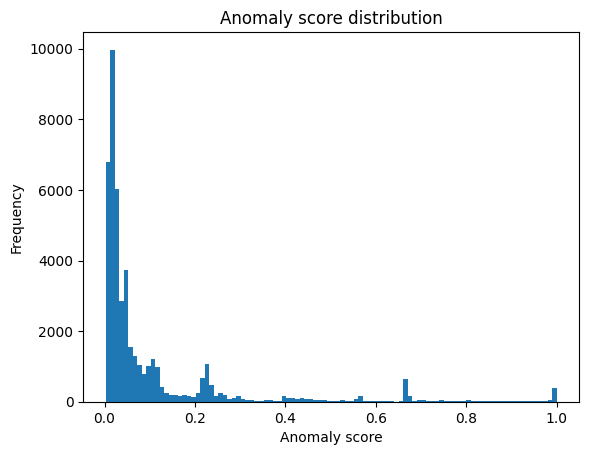

In [22]:
plot_anomaly_score_ditribution(model, train_loader)

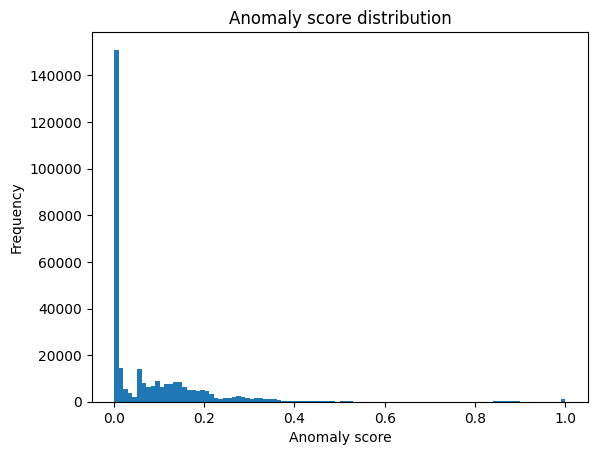

In [32]:
plot_anomaly_score_ditribution(model, val_loader, save_path="../out/plots/anomaly_score_distribution_validation_BatchNorm.png")

In [11]:
print("threshold:", model.threshold)

# model.threshold = 0.01

trainer.validate(model, val_loader)

AttributeError: 'BAE' object has no attribute 'threshold'

In [10]:
UNSWNB15_input_size = UNSWNB15_train_dataset[0][0].shape[0]
KNNCUP99_input_size = KDDCUP99_train_dataset[0][0].shape[0]
CICIDS2017_input_size = CICIDS2017_train_dataset[0][0].shape[0]

model = BAE(
    birch_threshold=0.1, 
    birch_branching_factor=50, 
    birch_n_clusters=3, 
    base_model=StandardAE, 
    input_size=CICIDS2017_input_size, 
    hidden_sizes=[256, 64, 12],
    dropout=0.0,
    initial_lr=2e-3, 
    linear_lr_start_factor=1, 
    linear_lr_end_factor=0.03, 
    linear_lr_total_iters=25
    )

model.set_tech_params(
    accelerator='gpu',
    batch_size=1024, 
    num_workers=11, 
    persistent_workers=True
)

model.fit(
    CICIDS2017_train_dataset, 
    birch_fit_sample_size = 10000,
    birch_fit_quantile = 0.99,
    experiment_name="BAE CICIDS2017",
    run_name="v1",
    max_epochs=50,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Experiment with name BAE CICIDS2017 not found. Creating it.
C:\Users\Szymon\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory bin_for_redundant_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 37.5 K | train
1 | decoder | Sequential | 37.5 K | train
-----------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
12        Modules in train mode
0   

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 37.5 K | train
1 | decoder | Sequential | 37.5 K | train
-----------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 37.5 K | train
1 | decoder | Sequential | 37.5 K | train
-----------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [12]:
metrics = model.evaluate(CICIDS2017_val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
metrics

{'accuracy': tensor(0.8106),
 'precision': tensor(0.8770),
 'recall': tensor(0.7226),
 'f1': tensor(0.7924),
 'auroc': tensor(0.8379, dtype=torch.float64)}

In [11]:
from sklearn.cluster import Birch
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

def plot_birch(data, birch_fit_sample_size, threshold=0.5, branching_factor=50, n_clusters=3, random_state=42):
    birch_fit_sample_size = birch_fit_sample_size
    birch_fit_sample_size = min(birch_fit_sample_size, len(data))
    rng = np.random.default_rng(random_state)
    birch_fit_sample_indices = rng.choice(len(data), size=birch_fit_sample_size, replace=False)
    birch_fit_samples = data.x[birch_fit_sample_indices].cpu().numpy()

    birch = Birch(
        threshold=threshold,
        branching_factor=branching_factor,
        n_clusters=n_clusters,
    )

    # birch.fit(birch_fit_samples)
    # labels = birch.predict(data.x.cpu().numpy())

    # labels = birch.fit_predict(birch_fit_samples)

    vec_magintude = np.linalg.norm(birch_fit_samples, axis=1)
    threshold = np.quantile(vec_magintude, 0.99)
    print("Threshold:", threshold)

    fit_filter = vec_magintude < threshold
    outlier_filter = vec_magintude >= threshold

    birch.fit(birch_fit_samples[fit_filter])
    labels = birch.predict(birch_fit_samples)
    labels[outlier_filter] = n_clusters

    pca = PCA(n_components=2, random_state=random_state)
    coords = pca.fit_transform(birch_fit_samples)
    
    # coords = pca.fit_transform(data.x.cpu().numpy())

    # print cardinality of clusters
    for i in range(n_clusters+1):
        print(f"Cluster {i}: {np.sum(labels == i)}")

    plt.figure(figsize=(10, 10))
    plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title("Birch Clustering")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label="Cluster")
    plt.show()

In [20]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

def plot_space(dataset, sample_size=10000, random_state=42):
    rng = np.random.default_rng(random_state)

    sample_size = min(sample_size, len(dataset))
    sample_indices = rng.choice(len(dataset), size=sample_size, replace=False)
    samples = dataset.x[sample_indices].cpu().numpy()

    vec_magintude = np.linalg.norm(samples, axis=1)
    threshold = np.quantile(vec_magintude, 0.99)
    print("Threshold:", threshold)
    fit_filter = vec_magintude < threshold
    outlier_filter = vec_magintude >= threshold
    samples = samples[fit_filter]

    pca = PCA(n_components=2)
    coords = pca.fit_transform(samples)

    colors = dataset.attack_cat.cpu().numpy()[sample_indices][fit_filter]

    plt.figure(figsize=(10, 10))
    plt.scatter(coords[:, 0], coords[:, 1], c=colors, alpha=0.5)
    plt.title("Dataset")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label="Attack category")
    plt.show()


Threshold: 22.79607059478767


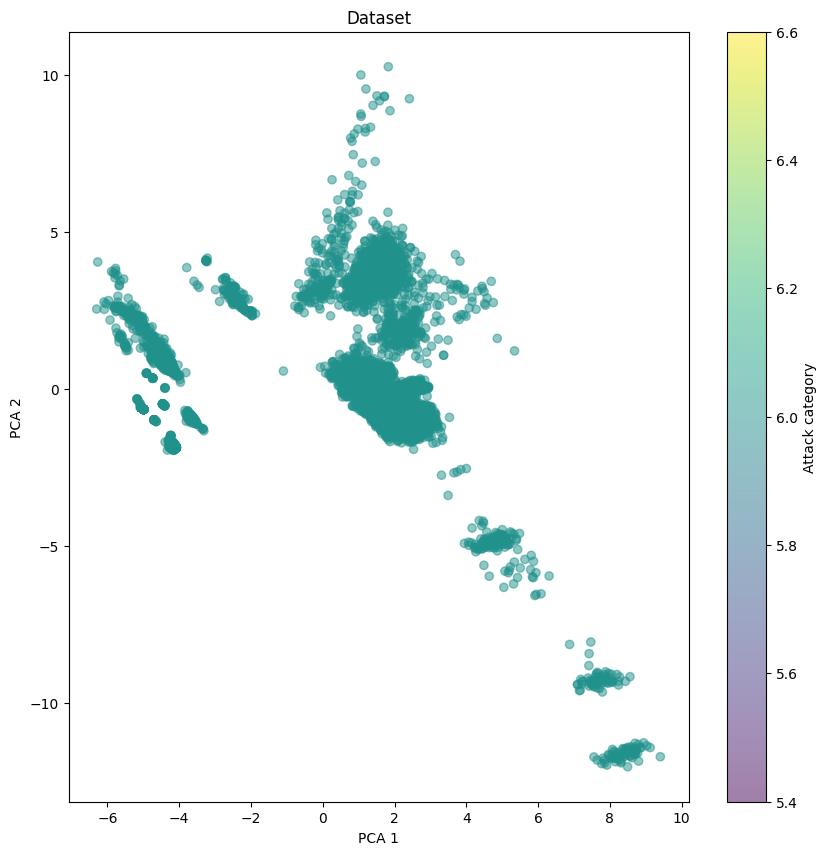

In [26]:
plot_space(UNSWNB15_train_dataset, sample_size=10000, random_state=42)

Threshold: 104.5523371887207
Cluster 0: 2373
Cluster 1: 1700
Cluster 2: 5827
Cluster 3: 100


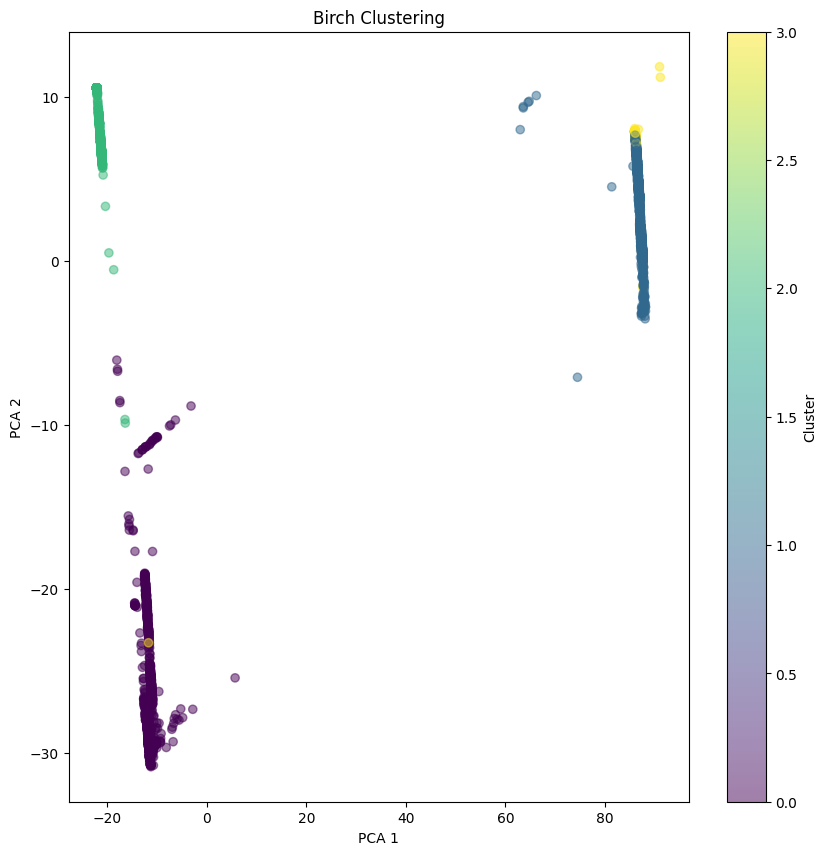

In [13]:
plot_birch(KDDCUP99_val_dataset, birch_fit_sample_size=10000, threshold=0.1, branching_factor=50, n_clusters=3, random_state=456)

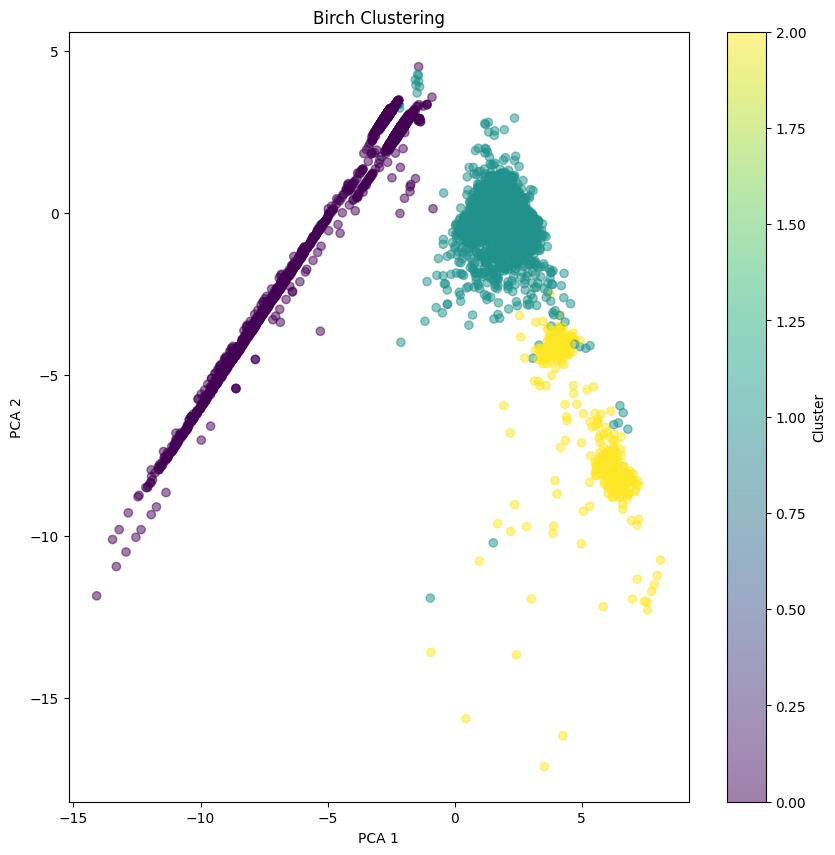

In [89]:
plot_birch(train_dataset, birch_fit_sample_size=10000, threshold=0.5, branching_factor=50, n_clusters=3, random_state=123)